## Startup dataset sample solution

The aim of the following notebook is finding a classification model having the highest scoring on the startup dataset.We Logistic Regression, Decision Tree Classification and Random Forest classification.

Our data consists of 234 observations of 51 variables. There are no missing values, duplicates and variables with single value.
The data is quite **balanced (49%-"1"and 51%-"0")**.From analytical point of view I think it is important not only to correctly predict startups that will succeed but also the ones that have failed. Therefore, we need a scoring maximizing predictive power of both. Thus, our comparison metrics would be `"roc_auc"` score
However, there is "ID" variable with unique categories, which we dropped not to have too many dummified columns.
Based on visualizations (heatmap, pairplot and boxplots) we can clearly see highly correlated variables (i.e. Company avg investment time and Company 1st investment time), and that are not different by Success(e.g. Founders fortune 1000 score by Success boxplot).We will use the info on not useful variables for data reduction.
At first we will perform Logistic Regression on scaled and non-scaled data, and next will use Decision Tree and Random Forest Classifiers.

## Descriptive Analysis

In [1]:
#data manipulation and visualization libraries
#for not showing warnings
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

#libraries for modelling and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,classification_report,roc_auc_score,roc_curve

In [2]:
data=pd.read_csv("Startup_data.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 51 columns):
ID                                          234 non-null object
Success                                     234 non-null int64
Company_Location                            234 non-null object
Company_raising_fund                        234 non-null object
Company_Industry_count                      234 non-null object
Company_mobile_app                          234 non-null object
Company_investor_count_seed                 234 non-null int64
Company_investor_count_Angel_VC             234 non-null int64
Company_cofounders_count                    234 non-null int64
Company_advisors_count                      234 non-null int64
Company_senior_team_count                   234 non-null int64
Company_top_Angel_VC_funding                234 non-null object
Company_repeat_investors_count              234 non-null int64
Founders_top_company_experience             234 non-null object
Founde

In [4]:
data.describe()

,Success,Company_investor_count_seed,Company_investor_count_Angel_VC,Company_cofounders_count,Company_advisors_count,Company_senior_team_count,Company_repeat_investors_count,Founder_university_quality,Founders_Popularity,Founders_fortune1000_company_score,...,Founders_Leadership_skills_score,Founders_Data_Science_skills_score,Founders_Business_Strategy_skills_score,Founders_Product_Management_skills_score,Founders_Sales_skills_score,Founders_Domain_skills_score,Company_competitor_count,Company_1st_investment_time,Company_avg_investment_time,Company_analytics_score
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,...,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000
mean,0.495726,1.448718,0.777778,2.072650,1.243590,4.290598,0.760684,1.905983,0.833333,0.272650,...,2.906936,6.362701,10.302821,3.468255,3.319419,4.732593,1.893162,16.705128,11.140988,0.940171
std,0.501054,2.737347,1.663086,1.160444,2.253386,2.475840,1.399875,1.791649,0.373477,0.382026,...,5.531376,10.133789,10.034738,5.083160,5.385571,7.731530,3.458106,21.025496,15.321532,1.050572
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.070833,0.000000
50%,0.000000,0.000000,0.000000,2.000000,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,2.941176,7.425214,0.000000,0.000000,0.000000,0.000000,12.000000,7.383333,1.000000
75%,1.000000,2.000000,1.000000,3.000000,1.000000,6.000000,1.000000,4.000000,1.000000,0.500000,...,4.750157,9.861111,17.647059,5.555556,5.555556,5.882353,3.000000,20.000000,12.000000,2.000000
max,1.000000,17.000000,9.000000,7.000000,13.000000,14.000000,10.000000,4.000000,1.000000,1.000000,...,40.000000,80.000000,47.058824,25.000000,33.333333,44.444444,28.000000,156.000000,156.000000,4.000000


In [5]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


In [6]:
data.select_dtypes(include="O").nunique()

ID                                          234
Company_Location                              3
Company_raising_fund                          2
Company_Industry_count                        3
Company_mobile_app                            2
Company_top_Angel_VC_funding                  2
Founders_top_company_experience               2
Founders_previous_company_employee_count      3
Founders_startup_experience                   2
Founders_big_5_experience                     2
Company_business_model                        3
Founders_experience                           3
Founders_global_exposure                      2
Founders_Industry_exposure                    3
Founder_education                             3
Founders_profile_similarity                   4
Founders_publications                         3
Company_incubation_investor                   2
Company_crowdsourcing                         2
Company_crowdfunding                          2
Company_big_data                        

In [7]:
# WE will drop ID as it has too many categories
data.drop("ID", axis=1, inplace=True)

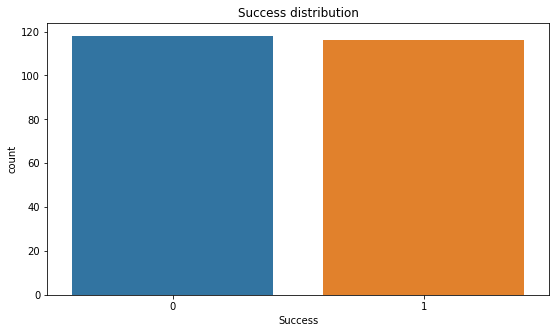

In [8]:
#let's visualise the distribution of y
plt.figure(figsize=(9,5))
sns.countplot(data.Success)
plt.title("Success distribution")
plt.show()

In [9]:
#lets count the benchmark for deposit subscription distribution
#we have balanced data
data.Success.value_counts(normalize=True).mul(100).rename("Success distribution in percentage")

0    50.42735
1    49.57265
Name: Success distribution in percentage, dtype: float64

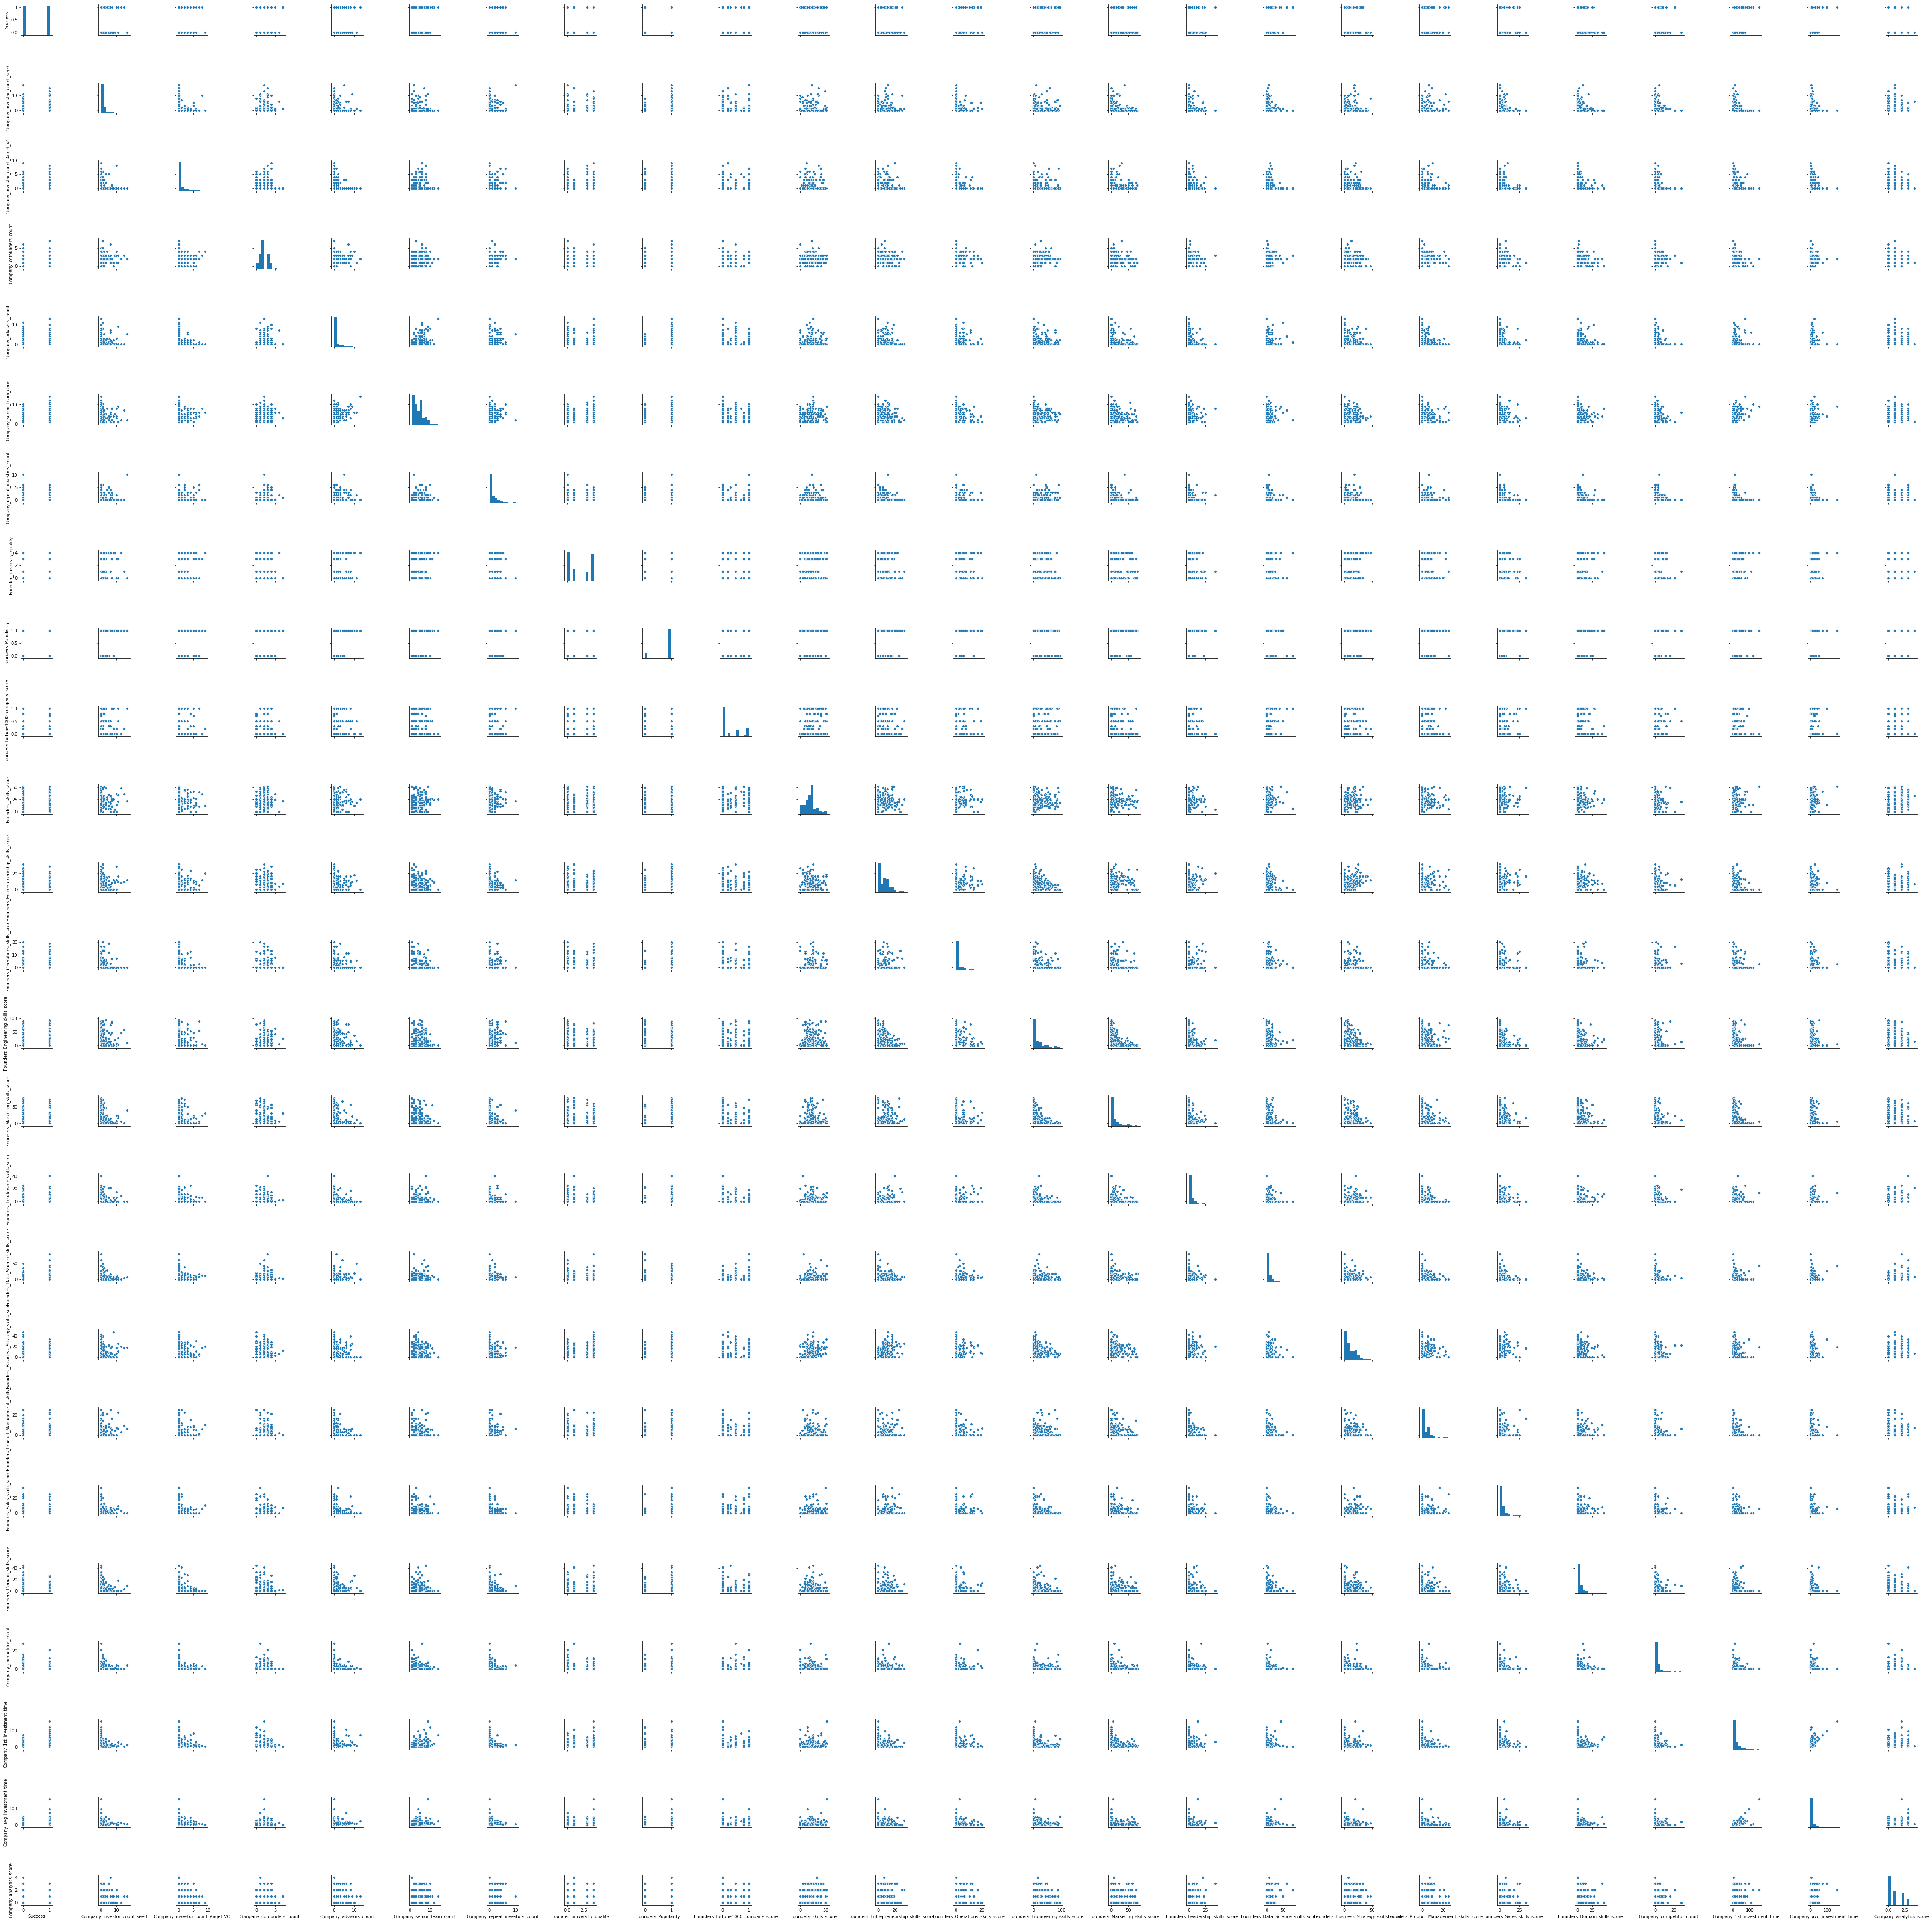

In [10]:
sns.pairplot(data)

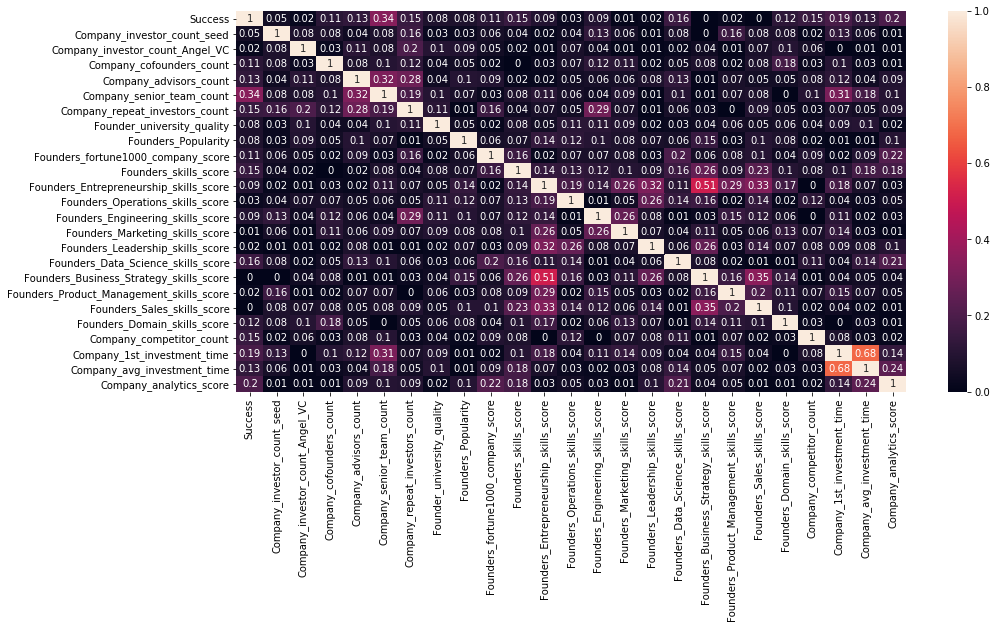

In [11]:
#Let's see the heatmap
plt.figure(figsize=(15,7))
sns.heatmap(data.corr().abs().round(2),annot=True)
plt.show()

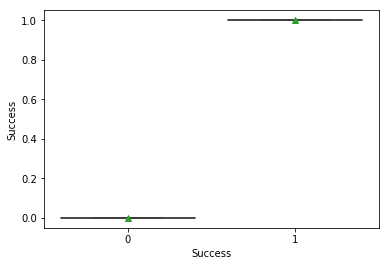

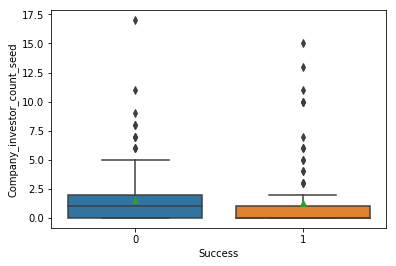

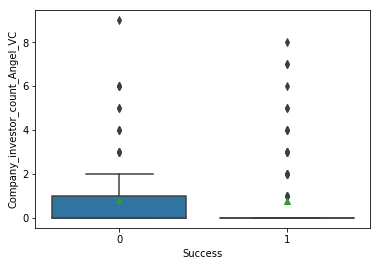

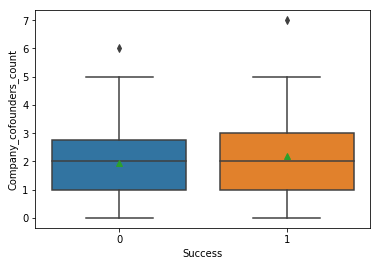

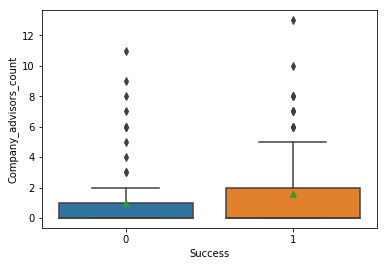

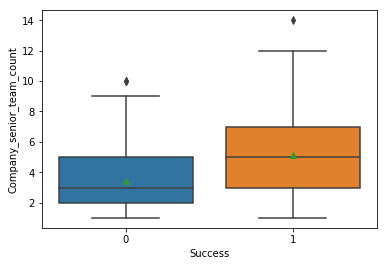

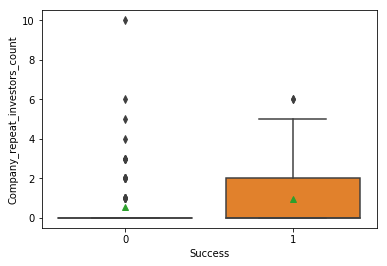

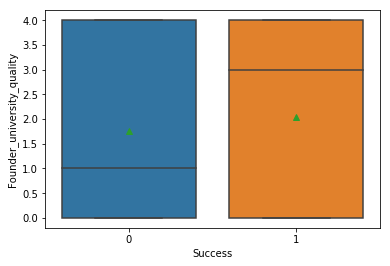

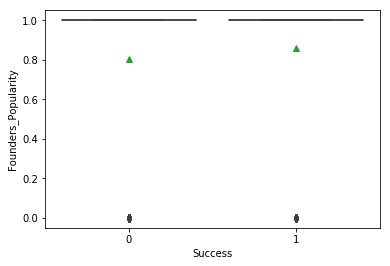

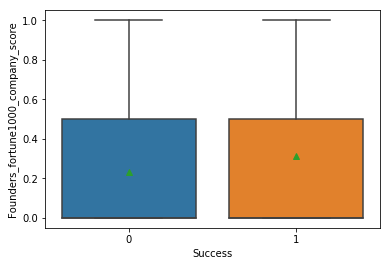

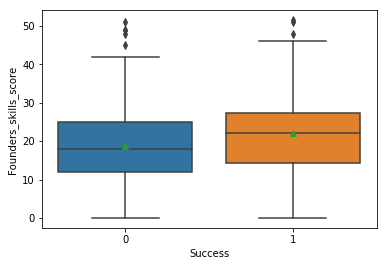

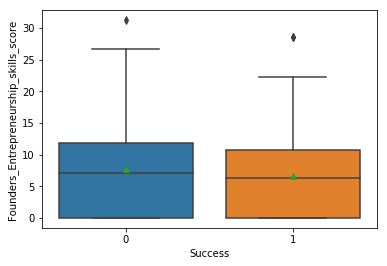

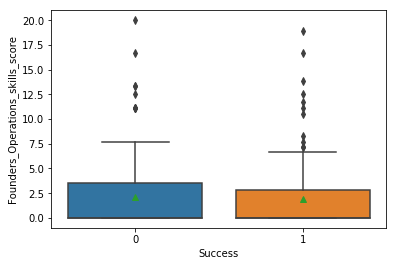

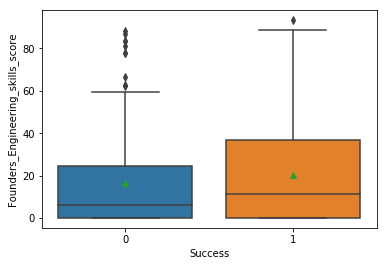

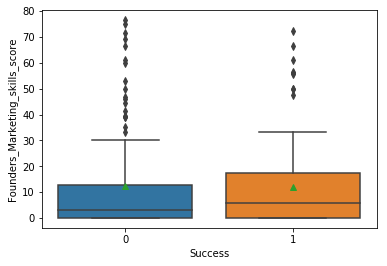

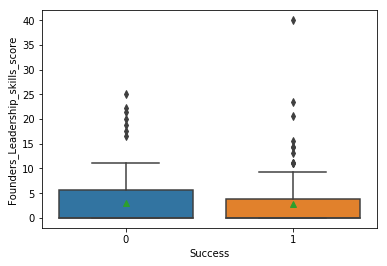

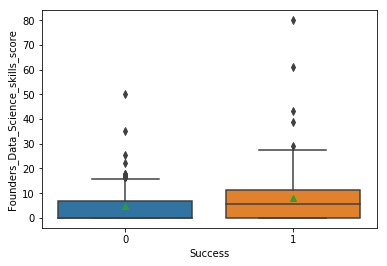

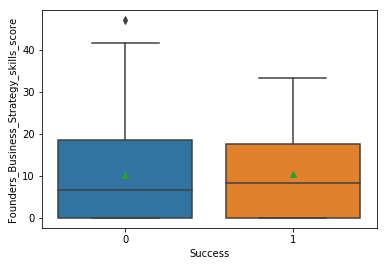

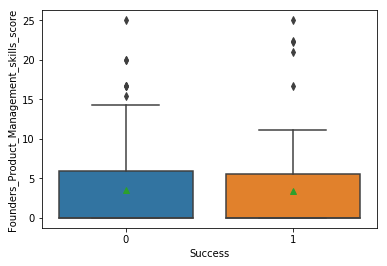

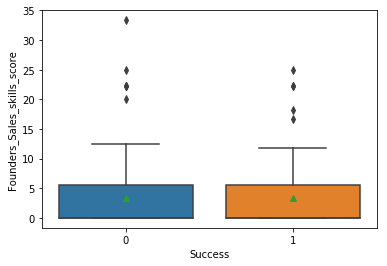

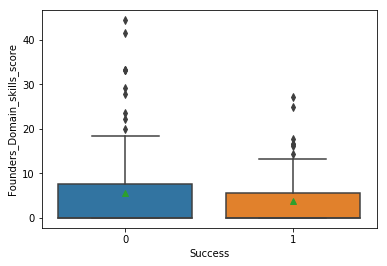

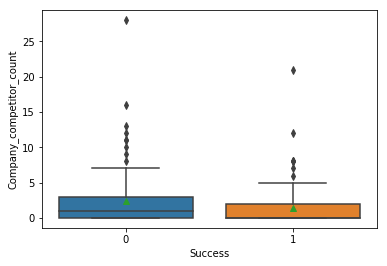

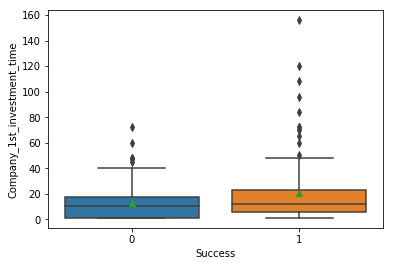

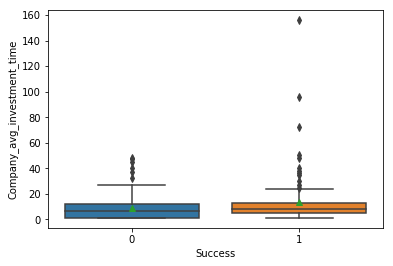

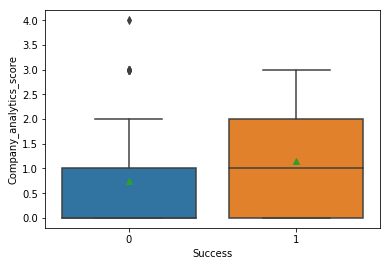

In [12]:
#Let's also see whether mean Churn differs by any of the categorical variables.
#to see that, let's visualize Churn by each categorical variable represented in boxplot.
for i in data.dtypes[data.dtypes!="O"].index.tolist():
    sns.boxplot(data=data,y=i,x="Success", showmeans=True)
    plt.show()

## Logistic Regression on non-scaled and scaled&reduced data

In [13]:
#Let's create dummy variables 
data_dum=pd.get_dummies(data,drop_first=True)
#separating X and Y
Y=data_dum["Success"]
X=data_dum.drop("Success",axis=1)
#let's split X and Y data into test and train datasets, test data is 20% of overall data
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.20, random_state=42)

In [14]:
#setting Logistic regression parameters range
param_logit={'class_weight':[None,'balanced'],
            'C':np.linspace(0.0001,5,100)}

In [15]:
#gridsearching to find best params
#verbose is for showing this sentence-"Fitting 3 folds for each of 200 candidates, totalling 600 fits"
gridsearch_logit = GridSearchCV(estimator=LogisticRegression(random_state=42),
                        param_grid=param_logit,
                        cv=3,scoring='roc_auc',verbose=1,n_jobs=2)
gridsearch_logit.fit(X0,Y0)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 281 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done 600 out of 600 | elapsed:    9.5s finished
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'class_weight': [None, 'balanced'], 'C': array([1.0000e-04, 5.0604e-02, ..., 4.9495e+00, 5.0000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [16]:
#best params for logit
gridsearch_logit.best_params_

{'C': 0.05060404040404041, 'class_weight': 'balanced'}

In [17]:
#let's construct logit with the best parameters 
logit=LogisticRegression(class_weight='balanced',C=0.05060404040404041,random_state=42).fit(X0,Y0)

In [18]:
#getting probabilities of being 1 (probability of having high final grade)
Y0_logit=logit.predict_proba(X0)[:,1]
Y1_logit=logit.predict_proba(X1)[:,1]

In [19]:
#calculating roc auc score
print("ROC_AUC Train not scaled Logit:",roc_auc_score(Y0,Y0_logit).round(2))
print("ROC_AUC Test not scaled Logit:",roc_auc_score(Y1,Y1_logit).round(2))
print("Mean 5-fold ROC AUC score for not scaled logit:",np.mean(cross_val_score(estimator=logit, X=X,y=Y,cv=5, scoring="roc_auc").round(2)))

ROC_AUC Train not scaled Logit: 0.84
ROC_AUC Test not scaled Logit: 0.62
Mean 5-fold ROC AUC score for not scaled logit: 0.636


We can see clear overfitting problem here, which was not solved using different ranges. Therefore, we will go on reducing variables based on initial 

### Logistic Regression on scaled&reduced data

In [20]:
data_tr=data.drop(["Company_avg_investment_time","Founders_Business_Strategy_skills_score","Founder_university_quality",
          "Founders_Popularity","Founders_fortune1000_company_score","Founders_Entrepreneurship_skills_score",
          "Founders_Product_Management_skills_score","Founders_Sales_skills_score"], axis=1)

In [21]:
X_tr=data_tr.drop("Success", axis=1)
Y_tr=data_tr["Success"]
X0_tr,X1_tr,Y0_tr,Y1_tr=train_test_split(X_tr,Y_tr, test_size=0.20,random_state=42)

In [22]:
#let's separate data for convenience
data_numeric=data_tr.select_dtypes(exclude="object") #categorical data
data_object=data_tr.select_dtypes(include="object")#dumeric
data_dummies=pd.get_dummies(data_object,prefix=data_object.columns,drop_first=True)#dummified categorical only
#scaling
scaler=StandardScaler()
scaler.fit(X0_tr[data_numeric.drop("Success",axis=1).columns.tolist()]) #lets's take all numeric variables except Final Grade

#fitting on X0 and transforming for both X0 and X1
X0_sc=pd.DataFrame(scaler.transform(X0_tr[data_numeric.drop("Success",axis=1).columns.tolist()]),
             columns=data_numeric.drop("Success",axis=1).columns.tolist()).join(data_dummies)
X1_sc=pd.DataFrame(scaler.transform(X1_tr[data_numeric.drop("Success",axis=1).columns.tolist()]),
             columns=data_numeric.drop("Success",axis=1).columns.tolist()).join(data_dummies)

C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Srbuhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Srbuhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [23]:
#setting Logistic regression parameters range
param_logit_tr={'class_weight':[None,'balanced'],
            'C':np.linspace(0.000001,5,300)}

In [24]:
#GridSearching Logit on scaled data
gs_logit_scaled=GridSearchCV(estimator=LogisticRegression(random_state=1),param_grid=param_logit_tr,
                        scoring="roc_auc",
                        cv=3,verbose=1, n_jobs=2).fit(X0_sc,Y0_tr)


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=2)]: Done 1040 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done 1800 out of 1800 | elapsed:   14.3s finished
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [25]:
gs_logit_scaled.best_params_

{'C': 1e-06, 'class_weight': 'balanced'}

In [26]:
logit_scaled=LogisticRegression(C=1e-06, class_weight="balanced", random_state=42).fit(X0_sc,Y0_tr)
#getting probabilities for scaled data
Y0_logit_sc=logit_scaled.predict_proba(X0_sc)[:,1]
Y1_logit_sc=logit_scaled.predict_proba(X1_sc)[:,1]

In [27]:
#calculating roc auc score and mean CV score: note that I haven't separately saved predicted probabilities
print("ROC_AUC Train for Scaled logit:",roc_auc_score(Y0_tr,Y0_logit_sc).round(2))
print("ROC_AUC Test for Scaled logit:",roc_auc_score(Y1_tr,Y1_logit_sc).round(2))
print("Mean 5-fold ROC AUC score for Scaled logit:",np.mean(cross_val_score(estimator=logit_scaled, X=pd.concat([X0_sc,X1_sc]),y=Y_tr,cv=5, scoring="roc_auc").round(2)))

ROC_AUC Train for Scaled logit: 0.8
ROC_AUC Test for Scaled logit: 0.72
Mean 5-fold ROC AUC score for Scaled logit: 0.54


## Decision Tree Classifier on scaled and non-scaled data

In [28]:
#setting up the ranges for hyperparameters
param_dt={"max_depth":range(5,15),"min_samples_leaf":range(20,125,5),
          "class_weight":["balanced", None],}

In [29]:
#Cross-Validated Gridsearch using parameters, use n_jobs=-1 for faster computing and 
gs_dt=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_grid=param_dt,scoring="roc_auc",cv=3, verbose=1, n_jobs=2)
gs_dt.fit(X0,Y0)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 420 candidates, totalling 1260 fits


[Parallel(n_jobs=2)]: Done 1260 out of 1260 | elapsed:    7.1s finished
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'max_depth': range(5, 15), 'min_samples_leaf': range(20, 125, 5), 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [30]:
#let's see the optimal parameters
gs_dt.best_params_

{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 35}

In [31]:
#fitting the model with best parameters
dt_grid=DecisionTreeClassifier(class_weight="balanced",max_depth=5,
                             min_samples_leaf=35, random_state=42).fit(X0,Y0)

#getting probabilities
Y0_dt_grid=dt_grid.predict_proba(X0)[:,1]
Y1_dt_grid=dt_grid.predict_proba(X1)[:,1]

In [32]:
#calculating roc auc score 
print("ROC_AUC Train for Decision Tree:",roc_auc_score(Y0,Y0_dt_grid).round(2))
print("ROC_AUC Test for Decision Tree:",roc_auc_score(Y1,Y1_dt_grid).round(2))
print("Mean 5-fold ROC AUC score for Decision Tree:",np.mean(cross_val_score(estimator=dt_grid, X=X,y=Y,cv=5, scoring="roc_auc")).round(2))


ROC_AUC Train for Decision Tree: 0.76
ROC_AUC Test for Decision Tree: 0.68
Mean 5-fold ROC AUC score for Decision Tree: 0.58


In [33]:
#setting up the ranges for hyperparameters
param_dt_tr={"max_depth":range(8,18),"min_samples_leaf":range(20,125,5),
          "class_weight":["balanced", None],}

In [34]:
#DT on scaled and reduced data
#Cross-Validated Gridsearch using parameters, use n_jobs=-1 for faster computing and 
gs_dt_tr_sc=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_grid=param_dt_tr,scoring="roc_auc",cv=3, verbose=1, n_jobs=2)
gs_dt_tr_sc.fit(X0_sc,Y0_tr)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 420 candidates, totalling 1260 fits


[Parallel(n_jobs=2)]: Done 928 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 1260 out of 1260 | elapsed:    6.7s finished
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'max_depth': range(8, 18), 'min_samples_leaf': range(20, 125, 5), 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [35]:
#let's see the optimal parameters
gs_dt_tr_sc.best_params_

{'class_weight': 'balanced', 'max_depth': 8, 'min_samples_leaf': 25}

In [36]:
#fitting the model with best parameters
dt_grid_sc=DecisionTreeClassifier(class_weight="balanced",max_depth=8,
                                 min_samples_leaf=35, random_state=42).fit(X0_sc,Y0_tr)

#getting probabilities
Y0_dt_grid_sc=dt_grid_sc.predict_proba(X0_sc)[:,1]
Y1_dt_grid_sc=dt_grid_sc.predict_proba(X1_sc)[:,1]

In [37]:
#calculating roc auc score 
print("ROC_AUC Train for Decision Tree scaled:",roc_auc_score(Y0_tr,Y0_dt_grid_sc).round(2))
print("ROC_AUC Test for Decision Tree scaled:",roc_auc_score(Y1_tr,Y1_dt_grid_sc).round(2))
print("Mean 5-fold ROC AUC score for Decision Tree scaled:",np.mean(cross_val_score(estimator=dt_grid_sc, X=pd.concat([X0_sc,X1_sc]),y=Y_tr,cv=5, scoring="roc_auc")).round(2))

ROC_AUC Train for Decision Tree scaled: 0.76
ROC_AUC Test for Decision Tree scaled: 0.59
Mean 5-fold ROC AUC score for Decision Tree scaled: 0.63


### Random Forest and Gradient Boosting on not-transformed data

In [38]:
#setting rf param grid
param_rf={  'max_depth': range(4,16),
            'min_samples_leaf': range(20,100, 5),
             'class_weight': ['balanced', None] }

In [39]:
#Random Forest Regression, using initial same parameters as for dt
#Cross-Validated Gridsearch using parameters, use n_jobs=-1 for faster computing
gs_rf=GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                   param_grid=param_rf,cv=3, scoring="roc_auc", verbose=1)
gs_rf.fit(X0,Y0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=1)]: Done 1152 out of 1152 | elapsed:   31.0s finished
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(4, 16), 'min_samples_leaf': range(20, 100, 5), 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [40]:
gs_rf.best_params_

{'class_weight': None, 'max_depth': 4, 'min_samples_leaf': 30}

In [49]:
#fitting the model with best parameters
rf=RandomForestClassifier(random_state=42,class_weight=None,max_depth=4,min_samples_leaf=30).fit(X0,Y0)

#getting probabilities
Y0_rf=rf.predict_proba(X0)[:,1]
Y1_rf=rf.predict_proba(X1)[:,1]

In [51]:
#calculating roc auc score 
print("ROC_AUC Train for Random Forest:",roc_auc_score(Y0,Y0_rf).round(2))
print("ROC_AUC Test for Random Forest:",roc_auc_score(Y1,Y1_rf).round(2))
#Mean cross val score for model with default hyperparameters
print("Mean 5-fold ROC AUC score for Random Forest:",np.mean(cross_val_score(estimator=rf, X=X,y=Y,cv=5, scoring="roc_auc",)).round(2))

ROC_AUC Train for Random Forest: 0.77
ROC_AUC Test for Random Forest: 0.67
Mean 5-fold ROC AUC score for Random Forest: 0.61


### Gradient Boosting Classifier

In [52]:
#gradient boosting doesn't have "class_weight" parameter, so setting new parameters dictionary
param_gb={'max_depth': range(4, 11),
          'min_samples_leaf': range(20, 140, 10),
         'n_estimators':range(200,320,20)}

In [53]:
#Random Forest Regression
#Cross-Validated Gridsearch using parameters, use n_jobs=-1 for faster computing and 
gs_gb=GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),param_grid=param_gb,
                   cv=3, scoring="roc_auc", verbose=1, n_jobs=2)
gs_gb.fit(X0,Y0)

Fitting 3 folds for each of 504 candidates, totalling 1512 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   27.5s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 1512 out of 1512 | elapsed:  1.8min finished
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'max_depth': range(4, 11), 'min_samples_leaf': range(20, 140, 10), 'n_estimators': range(200, 320, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [54]:
gs_gb.best_params_

{'max_depth': 4, 'min_samples_leaf': 30, 'n_estimators': 200}

In [55]:
#fitting the model with best parameters
gb=GradientBoostingClassifier(random_state=42,max_depth=4,min_samples_leaf=30, n_estimators=200).fit(X0,Y0)
#getting probabilities
Y0_gb=gb.predict_proba(X0)[:,1]
Y1_gb=gb.predict_proba(X1)[:,1]

In [56]:
#calculating roc auc score 
print("ROC_AUC Train for Tuned Gradient Boosting:",roc_auc_score(Y0,Y0_gb).round(2))
print("ROC_AUC Test for Tuned Gradinet Boosting:",roc_auc_score(Y1,Y1_gb).round(2))
#Mean cross val score for model with default hyperparameters
print("Mean 5-fold ROC AUC score for Gradinet Boosting Tuned hyperparameters:",np.mean(cross_val_score(estimator=gb, X=X,y=Y,cv=5, scoring="roc_auc",)).round(2))

ROC_AUC Train for Tuned Gradient Boosting: 1.0
ROC_AUC Test for Tuned Gradinet Boosting: 0.74
Mean 5-fold ROC AUC score for Gradinet Boosting Tuned hyperparameters: 0.66


In [57]:
print("Mean 5-fold ROC AUC score for not scaled LOGIT:",np.mean(cross_val_score(estimator=logit, X=X,y=Y,cv=5, scoring="roc_auc")).round(2))
print("Mean 5-fold ROC AUC score for Scaled LOGIT:",np.mean(cross_val_score(estimator=logit_scaled, X=pd.concat([X0_sc,X1_sc]),y=Y,cv=5, scoring="roc_auc")).round(2))
print("Mean 5-fold ROC AUC score for DT Tuned hyperparameters:",np.mean(cross_val_score(estimator=dt_grid, X=X,y=Y,cv=5, scoring="roc_auc")).round(2))
print("Mean 5-fold ROC AUC score for Random Forest Tuned hyperparameters:",np.mean(cross_val_score(estimator=rf, X=X,y=Y,cv=5, scoring="roc_auc",)).round(2))
print("Mean 5-fold ROC AUC score for Gradinet Boosting Tuned hyperparameters:",np.mean(cross_val_score(estimator=gb, X=X,y=Y,cv=5, scoring="roc_auc",)).round(2))

Mean 5-fold ROC AUC score for not scaled LOGIT: 0.64
Mean 5-fold ROC AUC score for Scaled LOGIT: 0.54
Mean 5-fold ROC AUC score for DT Tuned hyperparameters: 0.58
Mean 5-fold ROC AUC score for Random Forest Tuned hyperparameters: 0.61
Mean 5-fold ROC AUC score for Gradinet Boosting Tuned hyperparameters: 0.66


There are two competing models having high score on test set: Logit on not scaled data with 0.72 and Gradient Boosting with 0.74.
However, taking into account train-test gap and cross validation score, the final winning model is Gradient Boosting with 0.66 CV roc-auc score.